# **Problem Statement** :

Build a deep learning model to detect five gestures from videos captured through a smart tv's web camera. These gestures are used to control TV functionality

The five gestures and their corresponding TV controls are :

1.   Thumbs Up — Increase the volume
2.   Thumbs Down — Decrease the volume
3.   Left Swipe — 'Jump' backwards 10 seconds
4.   Right Swipe — 'Jump' forward 10 seconds
4.   Stop — Pause the movie.

**Dataset** :
The data set contains train and val folders contain 663 , 100 video frames respectively.
Two CSV files contain the frames and the corresponding class labels.
Each video is made of 30 frames. Frames come in two sizes — 120x160 and 320x320 as they are recorded from two different sources.

**Objectives** :
Develop a deep learning model that is able to classify the gesture based on the video frames.
The deep learning model should have High accuracy Low memory footprint ( to fit in a webcam memory (typically < 50MB)

Solution Approach :
Two model architectures have been experimented with



1.   Conv3D CNNs
2.   2D CNN + RNN

The 2D CNN + RNN is further divided in to two types as


*   Custom CNN + RNN
*   Pre-Trained CNN + RNN



Final Accuracy of 82% has been achieved using Conv3D CNN

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Get the Data

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'
output = '/content/Project_data.zip'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=027e9ada-c2bb-42a8-add9-764e276bdd87
To: /content/Project_data.zip
100%|██████████| 1.71G/1.71G [00:16<00:00, 100MB/s]


'/content/Project_data.zip'

## Extract the Data

In [ ]:
import zipfile
import os

zip_path = '/content/Project_data.zip'
extract_path = '/content/Project_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Check GPU
!nvidia-smi

Tue Jan 30 13:01:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import Libraries

In [ ]:
import skimage
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
from sys import getsizeof
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed

import cv2
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

import pandas as pd



from keras.applications import mobilenet

from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,GRU,GlobalAveragePooling2D,LSTM,MaxPool2D,ConvLSTM2D,GlobalAveragePooling1D

from tensorflow.keras.layers import Reshape

from keras.applications import ResNet152V2

In [ ]:
project_folder='/content/Project_data/Project_data'

In [ ]:

train_doc = np.random.permutation(open(f'{project_folder}/train.csv').readlines())
val_doc = np.random.permutation(open(f'{project_folder}/val.csv').readlines())

Trail_data_Percentage = 1   #0.3
# Randomly select 20% of the data for training and validation
Trail_train_doc = np.random.choice(train_doc, size=int(Trail_data_Percentage * len(train_doc)), replace=False)
Trail_val_doc = np.random.choice(val_doc, size=int(Trail_data_Percentage * len(val_doc)), replace=False)

## Check for Class Imbalance

In [ ]:
import pandas as pd
df = pd.DataFrame(train_doc, columns=['original_data'])
# Split at ';' and remove '\n'
df[['video_name', 'gesture_name', 'label']] = df['original_data'].str.split(';', expand=True)
df['label'] = df['label'].str.rstrip('\n').astype(int)

df.label.value_counts()

1    137
3    137
0    136
2    130
4    123
Name: label, dtype: int64

Defining Some Variables

In [ ]:
batch_size = 10 #experiment with the batch size
image_count = 15#30 # number of images to be used for each video
image_height=160
image_width=160
channels=3
num_classes=5 # number of classes
# image augmentation
augmentation = False
# retrain cnn
retrain = True
image_shape = (image_height,image_width,channels)

num_epochs = 50#45 #15 # choose the number of epochs

In [ ]:
def video_frames(mode='alternate',length=None) :
    if mode == 'alternate' :
        return [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    elif mode == 'all' :
        return list(range(30))
    elif mode == 'middle' :
        return list(range(5,25))
    elif (mode == 'random') and length :
        return sorted(list(np.random(0,29,length)))

frames_to_sample = video_frames(mode='alternate')   # Change this if you want

In [ ]:
input_shape=(image_count,image_width,image_height,channels)
curr_dt_time = datetime.datetime.now()


train_path = f'{project_folder}/train'
val_path = f'{project_folder}/val'

# Image Augmentation

In [ ]:
# image augmentation


# detecting skin tones. Since, gestures are performed by humans, masking the background and only detecting the skin could be a greate preprocessing step.
# The below function is skin tone filter
def skin_rules(R_Frame, G_Frame, B_Frame) :
    BRG_Max = np.maximum.reduce([B_Frame, G_Frame, R_Frame])
    BRG_Min = np.minimum.reduce([B_Frame, G_Frame, R_Frame])
    #at uniform daylight, The skin colour illumination's rule is defined by the following equation :
    Rule_1 = np.logical_and.reduce([R_Frame > 95, G_Frame > 40, B_Frame > 20 ,
                                 BRG_Max - BRG_Min > 15,abs(R_Frame - G_Frame) > 15,
                                 R_Frame > G_Frame, R_Frame > B_Frame])
    #the skin colour under flashlight or daylight lateral illumination rule is defined by the following equation :
    Rule_2 = np.logical_and.reduce([R_Frame > 220, G_Frame > 210, B_Frame > 170,
                         abs(R_Frame - G_Frame) <= 15, R_Frame > B_Frame, G_Frame > B_Frame])
    #Rule_1 U Rule_2
    RGB_Rule = np.logical_or(Rule_1, Rule_2)
    return RGB_Rule

# The below function detects skin and removes other scene elements.
def detect_skin(img) :

    mask = skin_rules(img[:,:,0], img[:,:,1], img[:,:,2])
    img[:,:,0] = img[:,:,0] * mask
    img[:,:,1] = img[:,:,1] * mask
    img[:,:,2] = img[:,:,2] * mask

    return img

def erode(img,kernel) :
    img_erode = np.zeros_like(img)

    img_erode[:,:,0] = cv2.erode(img[:,:,0],kernel)
    img_erode[:,:,1] = cv2.erode(img[:,:,1],kernel)
    img_erode[:,:,2] = cv2.erode(img[:,:,2],kernel)

    return img_erode

def dilate(img,kernel) :
    img_dilate = np.zeros_like(img)
    img_dilate[:,:,0] = cv2.dilate(img[:,:,0],kernel)
    img_dilate[:,:,1] = cv2.dilate(img[:,:,1],kernel)
    img_dilate[:,:,2] = cv2.dilate(img[:,:,2],kernel)

    return img_dilate


def closing(img,kernel) :
    return dilate(erode(img,kernel),kernel)

def opening(img,kernel) :
    return erode(dilate(img,kernel),kernel)


def open_close(img,kernel) :
    return closing(opening(img,kernel),kernel)

def close_open(img,kernel) :
    return closing(opening(img,kernel),kernel)

# opencv normalisation is used to prevent any math overflows.
def cv_normalise(img) :
    img_new = np.zeros_like(img)
    cv2.normalize(img, img_new , 0,1, cv2.NORM_MINMAX)

    assert round(np.max(img_new),1) == 1, 'Normalisation error'+ str(np.max(img_new))
    assert round(np.min(img_new),1) == 0 ,'Normalisation error'+ str(np.min(img_new))

    return img_new


# opening and then closing is performed to remove noise from images and then skin is detected
def preprocess_image(img,kernel) :

    img = open_close(img,kernel)
    img = detect_skin(img)

    return img

# Defining Some Functions

In [ ]:
# model training history plot
def plot_model_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
train_doc = np.random.permutation(open(f'{project_folder}/train.csv').readlines())
val_doc = np.random.permutation(open(f'{project_folder}/val.csv').readlines())
batch_size = 10 #experiment with the batch size
image_count = 30 # number of images to be used for each video
image_height=160
image_width=160
channels=3
num_classes=5 # number of classes
input_shape=(image_count,image_width,image_height,channels)
curr_dt_time = datetime.datetime.now()
train_path = f'{project_folder}/train'
val_path = f'{project_folder}/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [ ]:



def generator(source_path, folder_list, batch_size = batch_size, augmentation=augmentation):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[x for x in range(0,image_count)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size    # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,image_count,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])  #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,image_count,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
# Generator check

x,y = next(generator(val_path, val_doc, batch_size,augmentation=False))
print(x.shape)
print(y.shape)

x,y = next(generator(train_path, train_doc, batch_size))
print(x.shape)
print(y.shape)

Source path =  /content/Project_data/Project_data/val ; batch size = 10
(10, 30, 160, 160, 3)
(10, 5)
Source path =  /content/Project_data/Project_data/train ; batch size = 10
(10, 30, 160, 160, 3)
(10, 5)


In [ ]:
# Calling the generator function
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,augmentation=False)

Trail_train_generator = generator(train_path, Trail_train_doc, batch_size)
Trail_val_generator = generator(val_path, Trail_val_doc, batch_size, augmentation=False)

In [ ]:
model_name = 'Conv3D_Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=4,
)
# earlyStopping = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.00001,
# )

callbacks = [checkpoint,LR]

In [ ]:
num_train_sequences = len(Trail_train_doc)
print('Number of training sequences =', num_train_sequences)

num_val_sequences = len(Trail_val_doc)
print('Number of validation sequences =', num_val_sequences)

print('Batch size is =', batch_size)
num_epochs = 55
print('Number of epochs =', num_epochs)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print('steps_per_epoch = ',steps_per_epoch)
print('validation_steps = ',validation_steps)

Number of training sequences = 663
Number of validation sequences = 100
Batch size is = 10
Number of epochs = 55
steps_per_epoch =  67
validation_steps =  10


# Define Model

# 3D Convolution Model

In [ ]:

filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',
          input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu', kernel_regularizer='l2'))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(num_classes,activation='softmax'))

# Custom CNN + RNN

In [ ]:
# model = Sequential()
# model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(
    # MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(TimeDistributed(
    # Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
    # MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(num_classes, activation='softmax'))

# Custom CNN + LSTM

In [ ]:
# lstm_cells=64
# dense_neurons=64
# dropout=0.25
# model = Sequential()

# model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          # input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# # model.add(TimeDistributed(BatchNormalization()))
# # model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Flatten()))


# model.add(LSTM(lstm_cells))
# model.add(Dropout(dropout))

# model.add(Dense(dense_neurons,activation='relu'))
# model.add(Dropout(dropout))

# model.add(Dense(self.num_classes, activation='softmax'))

# CNN (MobileNet)  + RNN

In [ ]:
# Re-trained Mobile-Net CONV2D architecture followed by GRU (RNN)

# mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

# # CNN-RNN model
# model = Sequential()
# model.add(TimeDistributed(mobilenet_transfer,input_shape=(len(frames_to_sample),*image_shape)))

# for layer in model.layers:
    # layer.trainable = retrain

# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))

# model.add(GRU(gru_cells))
# model.add(Dropout(dropout_ratio))

# model.add(Dense(dense_layer,activation='relu'))
# model.add(Dropout(dropout_ratio))

# model.add(Dense(5, activation='softmax'))

# CNN(ResNet152V2) + RNN





In [ ]:
# model = Sequential()
# model.add(TimeDistributed(ResNet152V2(weights='imagenet', include_top=False),input_shape=input_shape, name='ResNet152V2', trainable=False))
# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(GRU(128, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

Following Code remains same

In [ ]:
optimiser = optimizers.Adam()     #learning_rate=0.0005

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 160, 160, 32   13856     
                             )                                   
                                                                 
 activation_1 (Activation)   (None, 30, 160, 160, 32   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 32)    0

In [ ]:
model.count_params()

2820805

In [ ]:
model.count_params()

2820805

In [ ]:

startTime = datetime.datetime.now()
print("Training start time = ", startTime)

model_history = model.fit_generator(
    Trail_train_generator,
    steps_per_epoch=steps_per_epoch,  # Set to the number of batches you want to process per epoch
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=Trail_val_generator,
    validation_steps=validation_steps,  # Set to the number of validation batches per epoch
    class_weight=None,
    workers=1,
    initial_epoch=0
)

endTime = datetime.datetime.now()
print("Training end time = ", endTime)

# Calculate and print total training time
totalTrainingTime = endTime - startTime
print("Total training time =", totalTrainingTime)

Training start time =  2024-01-30 13:01:21.930915
Source path =  /content/Project_data/Project_data/train ; batch size = 10
Epoch 1/55
67/67 [==============================] - ETA: 0s - loss: 2.8832 - categorical_accuracy: 0.3062Source path =  /content/Project_data/Project_data/val ; batch size = 10

Epoch 1: saving model to Conv3D_Model_2024-01-3013_01_18.749639/model-00001-2.88317-0.30618-2.52998-0.21000.h5
67/67 [==============================] - 132s 2s/step - loss: 2.8832 - categorical_accuracy: 0.3062 - val_loss: 2.5300 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/55
67/67 [==============================] - ETA: 0s - loss: 2.2063 - categorical_accuracy: 0.2935
Epoch 2: saving model to Conv3D_Model_2024-01-3013_01_18.749639/model-00002-2.20629-0.29353-2.22828-0.20000.h5
67/67 [==============================] - 39s 582ms/step - loss: 2.2063 - categorical_accuracy: 0.2935 - val_loss: 2.2283 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/55
67/67 [================

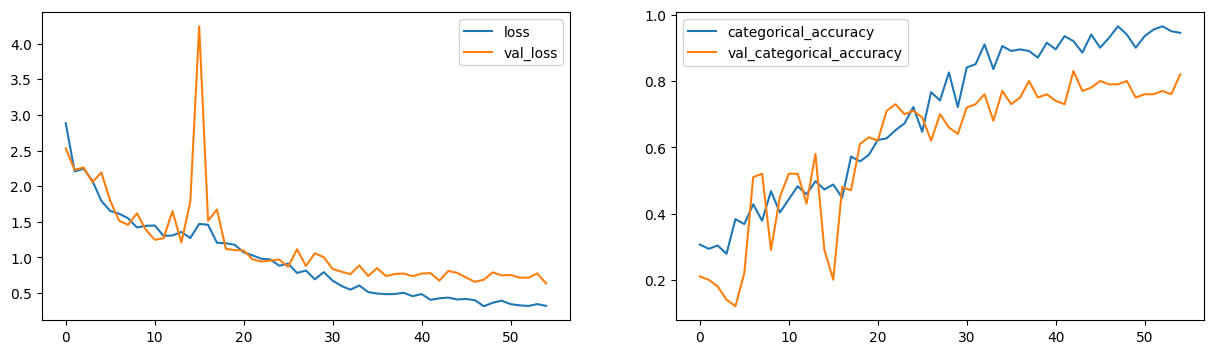

In [ ]:
plot_model_history(model_history)

## Copy The Best model to drive

In [ ]:
import shutil

# Specify the source path of the file
source_path = "/content/Conv3D_Model_2024-01-3013_01_18.749639/model-00055-0.32067-0.94527-0.63560-0.82000.h5"

# Specify the destination directory in your Google Drive
destination_directory = "/content/drive/MyDrive/Conv3D_Model/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Specify the destination path including the file name
destination_path = os.path.join(destination_directory, "model-00055-0.32067-0.94527-0.63560-0.82000.h5")

# Copy the file to your Google Drive
shutil.copyfile(source_path, destination_path)

'/content/drive/MyDrive/Conv3D_Model/model-00055-0.32067-0.94527-0.63560-0.82000.h5'